In [28]:
# Useful starting lines
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Load the data

In [29]:
import datetime
from helpers import *

height, weight, gender = load_data(sub_sample=False, add_outlier=False)
x, mean_x, std_x = standardize(height)
y, tx = build_model_data(x, weight)

In [30]:
y.shape, tx.shape

((10000,), (10000, 2))

### NB: throughout this laboratory the data has the following format: 
  * there are **N = 10000** data entries
  * **y** represents the column vector containing weight information -- that which we wish to predict/the output (see also the first page of $\texttt{exercise02.pdf}$). Its **shape** is **(N,)**.
  * **tx** represents the matrix $\tilde{X}$ formed by laterally concatenating a column vector of 1s to the column vector of height information -- the input data (see also the first page of $\texttt{exercise02.pdf}$). Its **shape** is **(N,2)**.

# 1. Computing the Cost Function
Fill in the `compute_loss` function below:

# Warmup questions

- The first column of tX is the offset term, the second column are the heights of all the people
- Each row of tX contains the offset term (1) and the height of one person
- So we can write the linear regression equation in matrix form without the offset term w0

a) L(w) = 1/2N * sum((y - tX.T@w)^2) = 1/2N * sum((e_n)^2) = 1/2N * e.T @ e

In [31]:
def compute_loss(y, tx, w):
    """Calculate the loss using either MSE or MAE.

    Args:
        y: numpy array of shape=(N, )
        tx: numpy array of shape=(N,2)
        w: numpy array of shape=(2,). The vector of model parameters.

    Returns:
        the value of the loss (a scalar), corresponding to the input parameters w.
    """
    # ***************************************************
    # MSE
    #loss = 1/(2*tx.shape[0]) * np.sum((y - tx.dot(w))**2) # only one dimension for the sum => no need to specify axis along which we want to sum
    #return loss

    # MAE
    loss = 1/(tx.shape[0]) * np.sum(np.abs(y - tx.dot(w)))
    return loss
    # ***************************************************
    raise NotImplementedError

In [32]:
#w = np.array([1,2]).T
#compute_loss(y, tx, w) 

# 2. Grid Search

Fill in the function `grid_search()` below:

In [33]:
# from costs import *


def grid_search(y, tx, grid_w0, grid_w1):
    """Algorithm for grid search.

    Args:
        y: numpy array of shape=(N, )
        tx: numpy array of shape=(N,2)
        grid_w0: numpy array of shape=(num_grid_pts_w0, ). A 1D array containing num_grid_pts_w0 values of parameter w0 to be tested in the grid search.
        grid_w1: numpy array of shape=(num_grid_pts_w1, ). A 1D array containing num_grid_pts_w1 values of parameter w1 to be tested in the grid search.

    Returns:
        losses: numpy array of shape=(num_grid_pts_w0, num_grid_pts_w1). A 2D array containing the loss value for each combination of w0 and w1
    """

    losses = np.zeros((len(grid_w0), len(grid_w1)))
    # ***************************************************
    for w0 in range(len(grid_w0)):
        for w1 in range(len(grid_w1)):
            losses[w0, w1] = compute_loss(y, tx, np.array([grid_w0[w0], grid_w1[w1]]))
    return losses
    # ***************************************************
    raise NotImplementedError

Let us play with the grid search demo now!

Grid Search: loss*=4.443009009145579, w0*=72.72727272727272, w1*=13.636363636363626, execution time=0.850 seconds


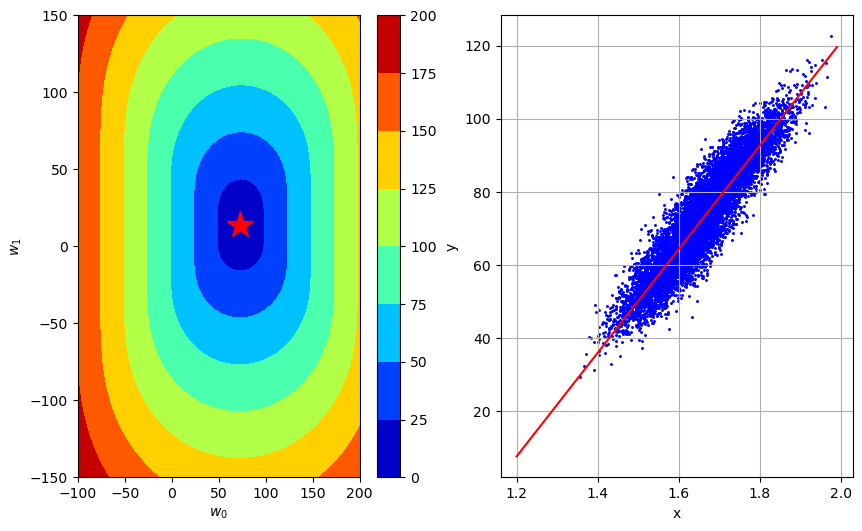

In [34]:
from grid_search import generate_w, get_best_parameters
from plots import grid_visualization

# Generate the grid of parameters to be swept
grid_w0, grid_w1 = generate_w(num_intervals=100)

# Start the grid search
start_time = datetime.datetime.now()
grid_losses = grid_search(y, tx, grid_w0, grid_w1)

# Select the best combinaison
loss_star, w0_star, w1_star = get_best_parameters(grid_w0, grid_w1, grid_losses)
end_time = datetime.datetime.now()
execution_time = (end_time - start_time).total_seconds()

# Print the results
print(
    "Grid Search: loss*={l}, w0*={w0}, w1*={w1}, execution time={t:.3f} seconds".format(
        l=loss_star, w0=w0_star, w1=w1_star, t=execution_time
    )
)

# Plot the results
fig = grid_visualization(grid_losses, grid_w0, grid_w1, mean_x, std_x, height, weight)
fig.set_size_inches(10.0, 6.0)
fig.savefig("grid_plot")  # Optional saving

# 3. Gradient Descent

Again, please fill in the functions `compute_gradient` below:

In [35]:
def compute_gradient(y, tx, w):
    """Computes the gradient at w.

    Args:
        y: numpy array of shape=(N, )
        tx: numpy array of shape=(N,2)
        w: numpy array of shape=(2, ). The vector of model parameters.

    Returns:
        An numpy array of shape (2, ) (same shape as w), containing the gradient of the loss at w.
    """
    # ***************************************************
    grad = -1/y.shape[0] * tx.T.dot(y - tx.dot(w))
    return grad
    # ***************************************************
    raise NotImplementedError

In [36]:
w = np.array([50, 10])
compute_gradient(y, tx, w)

array([-23.293922  ,  -3.47971243])

Please fill in the functions `gradient_descent` below:

In [37]:
def gradient_descent(y, tx, initial_w, max_iters, gamma):
    """The Gradient Descent (GD) algorithm.

    Args:
        y: numpy array of shape=(N, )
        tx: numpy array of shape=(N,2)
        initial_w: numpy array of shape=(2, ). The initial guess (or the initialization) for the model parameters
        max_iters: a scalar denoting the total number of iterations of GD
        gamma: a scalar denoting the stepsize

    Returns:
        losses: a list of length max_iters containing the loss value (scalar) for each iteration of GD
        ws: a list of length max_iters + 1 containing the model parameters as numpy arrays of shape (2, ),
            for each iteration of GD (as well as the final weights)
    """
    # Define parameters to store w and loss
    ws = [initial_w]
    losses = []
    w = initial_w
    for n_iter in range(max_iters):
        # ***************************************************
        grad = compute_gradient(y, tx, w)
        w = w - gamma*grad
        loss = compute_loss(y, tx, w)
        # ***************************************************

        # store w and loss
        ws.append(w)
        losses.append(loss)
        print(
            "GD iter. {bi}/{ti}: loss={l}, w0={w0}, w1={w1}".format(
                bi=n_iter, ti=max_iters - 1, l=loss, w0=w[0], w1=w[1]
            )
        )

    return losses, ws

Test your gradient descent function through gradient descent demo shown below:

In [38]:
# from gradient_descent import *
from plots import gradient_descent_visualization

# Define the parameters of the algorithm.
max_iters = 50
gamma = 0.6

# Initialization
w_initial = np.array([-1000, 1000])

# Start gradient descent.
start_time = datetime.datetime.now()
gd_losses, gd_ws = gradient_descent(y, tx, w_initial, max_iters, gamma)
end_time = datetime.datetime.now()

# Print result
exection_time = (end_time - start_time).total_seconds()
print("GD: execution time={t:.3f} seconds".format(t=exection_time))

GD iter. 0/49: loss=484.4241737336514, w0=-356.0236467987364, w1=408.087827460993
GD iter. 1/49: loss=193.8910943294635, w0=-98.43310551823123, w1=171.3229584453903
GD iter. 2/49: loss=77.72119867769308, w0=4.60311099397066, w1=76.6170108391493
GD iter. 3/49: loss=31.348740442959702, w0=45.81759759885148, w1=38.73463179665315
GD iter. 4/49: loss=13.105118991336942, w0=62.30339224080373, w1=23.58168017965467
GD iter. 5/49: loss=6.535929911049293, w0=68.8977100975846, w1=17.52049953285529
GD iter. 6/49: loss=4.800070740405854, w0=71.53543724029696, w1=15.096027274135544
GD iter. 7/49: loss=4.479164371313104, w0=72.59052809738189, w1=14.126238370647645
GD iter. 8/49: loss=4.431535956497809, w0=73.01256444021587, w1=13.738322809252486
GD iter. 9/49: loss=4.425202447853467, w0=73.18137897734947, w1=13.583156584694423
GD iter. 10/49: loss=4.424639444151559, w0=73.24890479220291, w1=13.521090094871198
GD iter. 11/49: loss=4.424812635885248, w0=73.27591511814428, w1=13.496263498941909
GD iter.

In [39]:
# Time Visualization
from ipywidgets import IntSlider, interact


def plot_figure(n_iter):
    fig = gradient_descent_visualization(
        gd_losses,
        gd_ws,
        grid_losses,
        grid_w0,
        grid_w1,
        mean_x,
        std_x,
        height,
        weight,
        n_iter,
    )
    fig.set_size_inches(10.0, 6.0)


interact(plot_figure, n_iter=IntSlider(min=1, max=len(gd_ws)))

interactive(children=(IntSlider(value=1, description='n_iter', max=51, min=1), Output()), _dom_classes=('widge…

<function __main__.plot_figure(n_iter)>

# 4. Stochastic gradient descent

In [40]:
for sample in batch_iter(y, tx, batch_size=1, num_batches=1):
    print(sample[1])
    print('\n')

[[ 1.         -1.40588033]]




In [41]:
def compute_stoch_gradient(y, tx, w):
    """Compute a stochastic gradient at w from a data sample batch of size B, where B < N, and their corresponding labels.

    Args:
        y: numpy array of shape=(B, )
        tx: numpy array of shape=(B,2)
        w: numpy array of shape=(2, ). The vector of model parameters.

    Returns:
        A numpy array of shape (2, ) (same shape as w), containing the stochastic gradient of the loss at w.
    """

    # ***************************************************
    grad = -1/y.shape[0] * tx.T.dot(y - tx.dot(w))
    return grad
    # ***************************************************



def stochastic_gradient_descent(y, tx, initial_w, batch_size, max_iters, gamma):
    """The Stochastic Gradient Descent algorithm (SGD).

    Args:
        y: numpy array of shape=(N, )
        tx: numpy array of shape=(N,2)
        initial_w: numpy array of shape=(2, ). The initial guess (or the initialization) for the model parameters
        batch_size: a scalar denoting the number of data points in a mini-batch used for computing the stochastic gradient
        max_iters: a scalar denoting the total number of iterations of SGD
        gamma: a scalar denoting the stepsize

    Returns:
        losses: a list of length max_iters containing the loss value (scalar) for each iteration of SGD
        ws: a list of length max_iters containing the model parameters as numpy arrays of shape (2, ), for each iteration of SGD
    """

    # Define parameters to store w and loss
    ws = [initial_w]
    losses = []
    w = initial_w

    for n_iter in range(max_iters):
        # ***************************************************
        for y_b, tx_b in batch_iter(y, tx, batch_size = batch_size, num_batches=1):
           grad = compute_stoch_gradient(y_b, tx_b, w)
           w = w - gamma*grad
           loss = compute_loss(y, tx, w) # Attention!!! Compute loss on whole dataset, not on the batch
           losses.append(loss)
           ws.append(w)
        # ***************************************************

        print(
            "SGD iter. {bi}/{ti}: loss={l}, w0={w0}, w1={w1}".format(
                bi=n_iter, ti=max_iters - 1, l=loss, w0=w[0], w1=w[1]
            )
        )
    return losses, ws

In [42]:
# from stochastic_gradient_descent import *

# Define the parameters of the algorithm.
max_iters = 50
gamma = 0.1
batch_size = 1

# Initialization
w_initial = np.array([0, 0])

# Start SGD.
start_time = datetime.datetime.now()
sgd_losses, sgd_ws = stochastic_gradient_descent(
    y, tx, w_initial, batch_size, max_iters, gamma
)
end_time = datetime.datetime.now()

# Print result
exection_time = (end_time - start_time).total_seconds()
print("SGD: execution time={t:.3f} seconds".format(t=exection_time))

SGD iter. 0/49: loss=65.47148427315139, w0=7.822437728953787, w1=5.891385510134981
SGD iter. 1/49: loss=59.40089188728248, w0=13.893030114822688, w1=-3.699990927248768
SGD iter. 2/49: loss=53.29583489002079, w0=19.99874117352525, w1=-4.019289165051829
SGD iter. 3/49: loss=51.15111572543975, w0=22.169177371816343, w1=-7.823762412979082
SGD iter. 4/49: loss=45.178511064712254, w0=28.225908616999753, w1=-8.072405928954081
SGD iter. 5/49: loss=41.19810282490663, w0=32.274148121258065, w1=-7.386491125911656
SGD iter. 6/49: loss=36.75537350910372, w0=36.8644809293487, w1=-6.733455652535461
SGD iter. 7/49: loss=32.83591777190014, w0=41.147329170356535, w1=-6.776316571640992
SGD iter. 8/49: loss=27.507911653525237, w0=46.07486420229716, w1=-1.709694745207928
SGD iter. 9/49: loss=24.849570659699904, w0=49.15768382427701, w1=-2.2914481345291513
SGD iter. 10/49: loss=22.98269477268826, w0=51.50255167511246, w1=-2.553650482813034
SGD iter. 11/49: loss=19.130200012089677, w0=55.100882117445614, w1=

In [43]:
# Time Visualization
from ipywidgets import IntSlider, interact


def plot_figure(n_iter):
    fig = gradient_descent_visualization(
        sgd_losses,
        sgd_ws,
        grid_losses,
        grid_w0,
        grid_w1,
        mean_x,
        std_x,
        height,
        weight,
        n_iter,
    )
    fig.set_size_inches(10.0, 6.0)


interact(plot_figure, n_iter=IntSlider(min=1, max=len(sgd_ws)))

interactive(children=(IntSlider(value=1, description='n_iter', max=51, min=1), Output()), _dom_classes=('widge…

<function __main__.plot_figure(n_iter)>

# 5. Effect of Outliers and MAE Cost Function

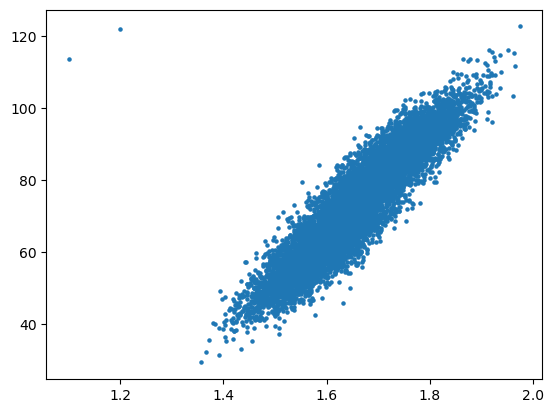

In [44]:
import datetime
from helpers import *
import matplotlib.pyplot as plt

# ***************************************************
height, weight, gender = load_data(sub_sample=False, add_outlier=True)
x, mean_x, std_x = standardize(height)
y, tx = build_model_data(x, weight)
# ***************************************************

plt.figure()
plt.scatter(height, weight, s = 5)

In [45]:
y.shape, tx.shape

((10002,), (10002, 2))

In [46]:
from plots import gradient_descent_visualization

# Define the parameters of the algorithm.
max_iters = 50
gamma = 0.7

# Initialization
w_initial = np.array([0, 0])

# Start gradient descent.
start_time = datetime.datetime.now()

# ***************************************************
gd_losses, gd_ws = gradient_descent(y, tx, w_initial, max_iters, gamma)
# ***************************************************

end_time = datetime.datetime.now()

# Print result
exection_time = (end_time - start_time).total_seconds()
print("GD: execution time={t:.3f} seconds".format(t=exection_time))

GD iter. 0/49: loss=21.99157154923259, w0=51.311949971831694, w1=9.375829281932628
GD iter. 1/49: loss=7.280095381209522, w0=66.70553496338118, w1=12.1885780665124
GD iter. 2/49: loss=4.725464430756561, w0=71.32361046084603, w1=13.03240270188633
GD iter. 3/49: loss=4.472685809789374, w0=72.70903311008549, w1=13.28555009249851
GD iter. 4/49: loss=4.451099939080772, w0=73.12465990485732, w1=13.361494309682165
GD iter. 5/49: loss=4.449500385562694, w0=73.24934794328888, w1=13.384277574837261
GD iter. 6/49: loss=4.449450823180492, w0=73.28675435481834, w1=13.39111255438379
GD iter. 7/49: loss=4.449476554283622, w0=73.29797627827718, w1=13.393163048247748
GD iter. 8/49: loss=4.449486479512005, w0=73.30134285531483, w1=13.393778196406936
GD iter. 9/49: loss=4.449489659566141, w0=73.30235282842612, w1=13.393962740854693
GD iter. 10/49: loss=4.449490658997496, w0=73.30265582035952, w1=13.39401810418902
GD iter. 11/49: loss=4.449490958826901, w0=73.30274671793954, w1=13.394034713189317
GD iter.

In [47]:
# Time Visualization
from ipywidgets import IntSlider, interact


def plot_figure(n_iter):
    fig = gradient_descent_visualization(
        gd_losses,
        gd_ws,
        grid_losses,
        grid_w0,
        grid_w1,
        mean_x,
        std_x,
        height,
        weight,
        n_iter,
    )
    fig.set_size_inches(10.0, 6.0)


interact(plot_figure, n_iter=IntSlider(min=1, max=len(gd_ws)))

interactive(children=(IntSlider(value=1, description='n_iter', max=51, min=1), Output()), _dom_classes=('widge…

<function __main__.plot_figure(n_iter)>

# 6. Subgradient descent

In [48]:
def compute_subgradient_mae(y, tx, w):
    """Compute a subgradient of the MAE at w.

    Args:
        y: numpy array of shape=(N, )
        tx: numpy array of shape=(N,2)
        w: numpy array of shape=(2, ). The vector of model parameters.

    Returns:
        A numpy array of shape (2, ) (same shape as w), containing the subgradient of the MAE at w.
    """
    # ***************************************************
    e = y - tx.dot(w)
    grad = -1/y.shape[0] * tx.T.dot(np.sign(e))
    return grad
    # ***************************************************

In [49]:
def subgradient_descent(y, tx, initial_w, max_iters, gamma):
    """The SubGradient Descent (SubGD) algorithm.

    Args:
        y: numpy array of shape=(N, )
        tx: numpy array of shape=(N,2)
        initial_w: numpy array of shape=(2, ). The initial guess (or the initialization) for the model parameters
        max_iters: a scalar denoting the total number of iterations of GD
        gamma: a scalar denoting the stepsize

    Returns:
        losses: a list of length max_iters containing the loss value (scalar) for each iteration of SubGD
        ws: a list of length max_iters containing the model parameters as numpy arrays of shape (2, ), for each iteration of SubGD
    """
    # Define parameters to store w and loss
    ws = [initial_w]
    losses = []
    w = initial_w
    for n_iter in range(max_iters):
        # ***************************************************
        grad = compute_subgradient_mae(y, tx, w)
        w = w - gamma*grad
        loss = compute_loss(y, tx, w)
        # ***************************************************
        ws.append(w)
        losses.append(loss)
        print(
            "SubGD iter. {bi}/{ti}: loss={l}, w0={w0}, w1={w1}".format(
                bi=n_iter, ti=max_iters - 1, l=loss, w0=w[0], w1=w[1]
            )
        )

    return losses, ws

In [50]:
# Define the parameters of the algorithm.
max_iters = 500
gamma = 0.7
batch_size = 1

# Initialization
w_initial = np.array([0, 0])

# Start SubSGD.
start_time = datetime.datetime.now()
subgd_losses, subgd_ws = subgradient_descent(y, tx, w_initial, max_iters, gamma)
end_time = datetime.datetime.now()

# Print result
exection_time = (end_time - start_time).total_seconds()
print("SubGD: execution time={t:.3f} seconds".format(t=exection_time))

SubGD iter. 0/499: loss=72.60278567404525, w0=0.7, w1=-6.36518987443561e-17
SubGD iter. 1/499: loss=71.90278567404523, w0=1.4, w1=-1.273037974887122e-16
SubGD iter. 2/499: loss=71.20278567404524, w0=2.0999999999999996, w1=-1.9095569623306827e-16
SubGD iter. 3/499: loss=70.50278567404526, w0=2.8, w1=-2.546075949774244e-16
SubGD iter. 4/499: loss=69.80278567404524, w0=3.5, w1=-3.182594937217805e-16
SubGD iter. 5/499: loss=69.10278567404525, w0=4.2, w1=-3.819113924661366e-16
SubGD iter. 6/499: loss=68.40278567404523, w0=4.9, w1=-4.455632912104926e-16
SubGD iter. 7/499: loss=67.70278567404524, w0=5.6000000000000005, w1=-5.092151899548488e-16
SubGD iter. 8/499: loss=67.00278567404526, w0=6.300000000000001, w1=-5.728670886992049e-16
SubGD iter. 9/499: loss=66.30278567404524, w0=7.000000000000001, w1=-6.36518987443561e-16
SubGD iter. 10/499: loss=65.60278567404525, w0=7.700000000000001, w1=-7.001708861879171e-16
SubGD iter. 11/499: loss=64.90278567404525, w0=8.4, w1=-7.638227849322732e-16
Sub

In [51]:
from ipywidgets import IntSlider, interact


def plot_figure(n_iter):
    fig = gradient_descent_visualization(
        subgd_losses,
        subgd_ws,
        grid_losses,
        grid_w0,
        grid_w1,
        mean_x,
        std_x,
        height,
        weight,
        n_iter,
    )
    fig.set_size_inches(10.0, 6.0)


interact(plot_figure, n_iter=IntSlider(min=1, max=len(subgd_ws)))

interactive(children=(IntSlider(value=1, description='n_iter', max=501, min=1), Output()), _dom_classes=('widg…

<function __main__.plot_figure(n_iter)>

# Stochastic Subgradient Descent

**NB** for the computation of the subgradient you can reuse the `compute_subgradient` method that you implemented above, just making sure that you pass in a minibatch as opposed to the full data.

In [57]:
def stochastic_subgradient_descent(y, tx, initial_w, batch_size, max_iters, gamma):
    """Compute a stochastic subgradient at w from a data sample batch of size B, where B < N, and their corresponding labels.

    Args:
        y: numpy array of shape=(B, )
        tx: numpy array of shape=(B,2)
        initial_w: numpy array of shape=(2, ). The initial guess (or the initialization) for the model parameters
        batch_size: a scalar denoting the number of data points in a mini-batch used for computing the stochastic subgradient
        max_iters: a scalar denoting the total number of iterations of SubSGD
        gamma: a scalar denoting the stepsize

    Returns:
        losses: a list of length max_iters containing the loss value (scalar) for each iteration of SubSGD
        ws: a list of length max_iters containing the model parameters as numpy arrays of shape (2, ), for each iteration of SubSGD
    """

    # Define parameters to store w and loss
    ws = [initial_w]
    losses = []
    w = initial_w

    for n_iter in range(max_iters):
        # ***************************************************
        for y_b, tx_b in batch_iter(y, tx, batch_size = batch_size, num_batches=1):
            grad = compute_subgradient_mae(y_b, tx_b, w)
            w = w - gamma*grad
            loss = compute_loss(y, tx, w)
            ws.append(w)
            losses.append(loss)
        # ***************************************************
        print(
            "SubSGD iter. {bi}/{ti}: loss={l}, w0={w0}, w1={w1}".format(
                bi=n_iter, ti=max_iters - 1, l=loss, w0=w[0], w1=w[1]
            )
        )
    return losses, ws

In [58]:
# Define the parameters of the algorithm.
max_iters = 500
gamma = 0.7
batch_size = 1

# Initialization
w_initial = np.array([0, 0])

# Start SubSGD.
start_time = datetime.datetime.now()
subsgd_losses, subsgd_ws = stochastic_subgradient_descent(
    y, tx, w_initial, batch_size, max_iters, gamma
)
end_time = datetime.datetime.now()

# Print result
exection_time = (end_time - start_time).total_seconds()
print("SubSGD: execution time={t:.3f} seconds".format(t=exection_time))

SubSGD iter. 0/499: loss=72.60278567404525, w0=0.7, w1=0.5675811934295564
SubSGD iter. 1/499: loss=71.90278567404526, w0=1.4, w1=0.9195474825632259
SubSGD iter. 2/499: loss=71.20278567404524, w0=2.0999999999999996, w1=1.2844507399190268
SubSGD iter. 3/499: loss=70.50278567404526, w0=2.8, w1=1.473605402408566
SubSGD iter. 4/499: loss=69.80278567404524, w0=3.5, w1=0.9226908961005335
SubSGD iter. 5/499: loss=69.10278567404524, w0=4.2, w1=0.8570933293578947
SubSGD iter. 6/499: loss=68.40278567404525, w0=4.9, w1=-0.2221042121114548
SubSGD iter. 7/499: loss=67.70278567404524, w0=5.6000000000000005, w1=-0.6524684086545661
SubSGD iter. 8/499: loss=67.00278567404526, w0=6.300000000000001, w1=-1.6970638770195063
SubSGD iter. 9/499: loss=66.30278567404527, w0=7.000000000000001, w1=-2.4113452283877663
SubSGD iter. 10/499: loss=65.60278567404525, w0=7.700000000000001, w1=-2.309641823524137
SubSGD iter. 11/499: loss=64.90278567404526, w0=8.4, w1=-2.8010421290680654
SubSGD iter. 12/499: loss=64.20278

In [54]:
from ipywidgets import IntSlider, interact


def plot_figure(n_iter):
    fig = gradient_descent_visualization(
        subsgd_losses,
        subsgd_ws,
        grid_losses,
        grid_w0,
        grid_w1,
        mean_x,
        std_x,
        height,
        weight,
        n_iter,
    )
    fig.set_size_inches(10.0, 6.0)


interact(plot_figure, n_iter=IntSlider(min=1, max=len(subsgd_ws)))

interactive(children=(IntSlider(value=1, description='n_iter', max=501, min=1), Output()), _dom_classes=('widg…

<function __main__.plot_figure(n_iter)>